In [12]:
# TOBIT 
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [13]:

def make_features(df: pd.DataFrame) -> pd.DataFrame:
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)
    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: np.sqrt((x.shift(1) ** 2)
                                       .rolling(window=30, min_periods=1).sum()))
    )

    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-60)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna(subset=['rv_future'])   
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [14]:
# 1) Load and feature‐engineer
df = pd.read_csv("/Users/tobitlouis/Desktop/Data/S27FE-10K.csv")
df = make_features(df)               # your function from above
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()                     # drop any row missing *any* feature or target

# 2) Define features & target
feature_cols = [
    'seconds_in_bucket', 'mid_price','spread',
    'imbalance','imbalance_lag1','imbalance_lag2',
    'book_pressure','book_pressure_lag1','book_pressure_lag2',
    'microprice','normalized_spread','OBI_L2',
    'LOB_entropy','LOB_entropy_normalized',
    'log_return','log_return_lag1','log_return_lag2',
    'bipower_var','wap','log_wap_return',
    'rolling_vol_30','rolling_imbalance_mean_30',
]
target_col = 'rv_future'

X = df[feature_cols].values
y = df[target_col].values  # already shifted

# 3) Train/validation/test split
#    First split off test, then within train do CV
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sliding windows
def create_windows(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])  # predict volatility after the window
    return np.array(Xs), np.array(ys)

# Set your window size (e.g., 60 seconds)
window_size = 60
X_seq, y_seq = create_windows(X_scaled, y, window_size)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42
)

/var/folders/1x/1h6q844j3q17xnp4kqxpsnz00000gn/T/ipykernel_79824/1733880287.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [15]:
print(np.isnan(X_train).sum(), np.isnan(y_train).sum())


0 0


In [16]:
print(X_train.min(), X_train.max())
print(y_train.min(), y_train.max())


-17.894495600762454 16.473076732078976
0.0 0.008517804449107422


In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256

train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [18]:
import torch
import torch.nn as nn

class VolatilityCNN(nn.Module):
    def __init__(self, num_features):
        super().__init__()

        # 1st Conv layer: input features → 64
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=5)
        self.bn1 = nn.BatchNorm1d(64)

        # 2nd Conv layer: 64 → 128
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(128)

        # 3rd Conv layer: 128 → 256
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(256)

        # 4th Conv layer: 256 → 512
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(512)

        # Adaptive pooling to reduce sequence to 1
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

        # Fully connected output layer
        self.fc = nn.Linear(512, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # → (batch, features, time)

        x = torch.relu(self.bn1(self.conv1(x)))  # → (batch, 64, time')
        x = torch.relu(self.bn2(self.conv2(x)))  # → (batch, 128, time'')
        x = torch.relu(self.bn3(self.conv3(x)))  # → (batch, 256, time''')
        x = torch.relu(self.bn4(self.conv4(x)))  # → (batch, 512, time'''')

        x = self.pool(x)                         # → (batch, 512, 1)
        x = x.view(x.size(0), -1)                # → (batch, 512)
        x = self.dropout(x)
        out = self.fc(x)                         # → (batch, 1)

        return out.squeeze()                     # Final shape: (batch,)


In [19]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn

# 1. Define the model
model = VolatilityCNN(num_features=X_train.shape[2])

# 2. Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Create the scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# 4. Define the loss function
criterion = nn.MSELoss()


In [20]:
for epoch in range(50):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

    # Adjust the learning rate
    scheduler.step()

    # Optional: show current LR
    current_lr = scheduler.get_last_lr()[0]
    print(f"Learning rate: {current_lr:.6f}")



Epoch 1, Loss: 1.9308
Learning rate: 0.001000
Epoch 2, Loss: 0.2743
Learning rate: 0.001000
Epoch 3, Loss: 0.1956
Learning rate: 0.001000
Epoch 4, Loss: 0.1725
Learning rate: 0.001000
Epoch 5, Loss: 0.1390
Learning rate: 0.001000
Epoch 6, Loss: 0.1214
Learning rate: 0.001000
Epoch 7, Loss: 0.1041
Learning rate: 0.001000
Epoch 8, Loss: 0.0933
Learning rate: 0.001000
Epoch 9, Loss: 0.0862
Learning rate: 0.001000
Epoch 10, Loss: 0.0742
Learning rate: 0.000500
Epoch 11, Loss: 0.0663
Learning rate: 0.000500
Epoch 12, Loss: 0.0616
Learning rate: 0.000500
Epoch 13, Loss: 0.0605
Learning rate: 0.000500
Epoch 14, Loss: 0.0585
Learning rate: 0.000500
Epoch 15, Loss: 0.0538
Learning rate: 0.000500
Epoch 16, Loss: 0.0509
Learning rate: 0.000500
Epoch 17, Loss: 0.0488
Learning rate: 0.000500
Epoch 18, Loss: 0.0446
Learning rate: 0.000500
Epoch 19, Loss: 0.0442
Learning rate: 0.000500
Epoch 20, Loss: 0.0395
Learning rate: 0.000250
Epoch 21, Loss: 0.0400
Learning rate: 0.000250
Epoch 22, Loss: 0.0386

In [21]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

model.eval()
with torch.no_grad():
    y_preds_log = []
    y_trues_log = []
    
    for X_batch, y_batch in test_loader:
        y_pred_log = model(X_batch)  # model outputs log1p(y)
        y_preds_log.append(y_pred_log.numpy())
        y_trues_log.append(y_batch.numpy())  # y_batch should also be log1p(y)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

# Concatenate predictions and true values
y_preds_log = np.concatenate(y_preds_log)
y_trues_log = np.concatenate(y_trues_log)

# Invert the log1p transformation
y_preds = np.expm1(y_preds_log)
y_trues = np.expm1(y_trues_log)

ql = qlike_safe(y_test, y_preds)

# Evaluate in original scale
print(f"MSE: {mean_squared_error(y_trues, y_preds):.4f}")
print(f"R^2: {r2_score(y_trues, y_preds):.4f}")
print("QLIKE:", ql)



MSE: 0.0002
R^2: -138.4825
QLIKE: 51251.29354423939


In [22]:
# After inference
print("Mean prediction (log scale):", y_preds_log.mean())
print("First 5 predictions (log):", y_preds_log[:5])
print("First 5 truths (log):", y_trues_log[:5])


Mean prediction (log scale): 0.0031607444
First 5 predictions (log): [-0.00134086  0.01439785  0.00901982  0.02029677 -0.00345706]
First 5 truths (log): [0.00118163 0.00257323 0.00269313 0.00035054 0.00056174]


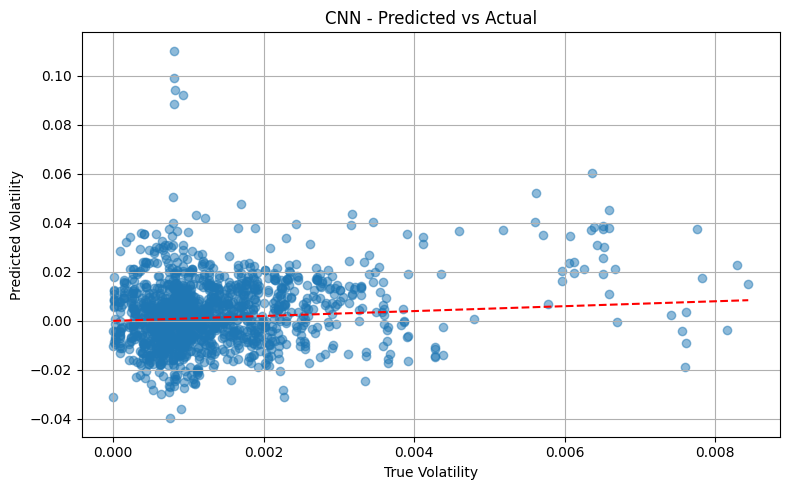

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_trues, y_preds, alpha=0.5)
plt.plot([y_trues.min(), y_trues.max()], [y_trues.min(), y_trues.max()], 'r--')
plt.xlabel("True Volatility")
plt.ylabel("Predicted Volatility")
plt.title("CNN - Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()
